# Markov Chain Analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Load dependencies

In [11]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn, plot_histogram_jn, plot_points_on_map_jn
from msci.analysis.markov_chain import *

In [14]:
from sklearn import preprocessing
from scipy.stats import linregress

## Get data

In [15]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [16]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [17]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)

## Markov Chain

In [18]:
r_signal_df = signal_df[
    signal_df.store_id.notnull() & 
    (signal_df.store_id.str[0] == 'B') & 
    signal_df.mac_address.isin(shopper_df.mac_address)
]

In [67]:
r_signal_mac_address_df = r_signal_df.groupby('mac_address')['store_id'].apply(len)
mac_address_len = r_signal_mac_address_df.as_matrix()

In [68]:
le = preprocessing.LabelEncoder()
le.fit(r_signal_df.sort_values('store_id').store_id.unique())
K = len(le.classes_)
le_Y = le.transform(r_signal_df.sort_values('mac_address').store_id)

onehot = preprocessing.OneHotEncoder()
onehot.fit(le_Y[:, np.newaxis])
onehot_Y = onehot.transform(le_Y[:, np.newaxis])

In [69]:
N = np.zeros((K, K))
N1 = np.zeros(K)

L = len(mac_address_len)

for l in range(L):
    
    seq_start = sum(mac_address_len[:l])
    seq_end = sum(mac_address_len[:l+1])
    
    seq = onehot_Y[seq_start: seq_end].toarray()
    
    T = len(seq)
    
    N1 += seq[0]
        
    if T > 1:
        for t in range(1, T):
            N += np.outer(seq[t-1], seq[t])
        
pi = N1 / N1.sum()
A = (N.T / N.sum(axis=1)).T

In [61]:
names, A, pi = manual_matrix(r_signal_df, return_permitted=True, jn=True)

B219 0.07608446178563232


In [66]:
shop_probs_df = process(names, A, pi, shop_df, rep = 1000)
shop_probs_df.head()

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,pi,piA,avpiA
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,0.062773,0.086887,0.294914
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,0.051985,0.044784,0.024697
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464,0.019394,0.025904,0.036127
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449,0.027083,0.035989,0.035705
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711,0.023984,0.030598,0.038962


In [20]:
val = np.dot(pi, A.dot(A).dot(A).dot(A).dot(A).dot(A).dot(A).dot(A).dot(A).dot(A).dot(A))

pi_t = np.copy(pi)
val2 = pi_t

for i in range(19):
    pi_t = pi_t.dot(A)
    pi_t /= sum(pi_t)
    val2 += pi_t
    val2 /= sum(val2)

store_pi_df = pd.DataFrame(
    np.array([
        names, 
        pi, 
        val / sum(val),
        val2 / sum(val2),
    ]).T, 
    columns=('store_id', 'pi', 'piA', 'avpiA')
)

In [35]:
ssv = steady_state_vector(A, pi, repeats=20, analytic=False)
steady_state = ssv[0]
store_pi_df = pd.DataFrame(
    np.array([
        names, 
        pi, 
        A.dot(pi),
        steady_state,
    ]).T, 
    columns=('store_id', 'pi', 'piA', 'avpiA')
)

In [68]:
# Output transition matrix and shop names
np.savez(
    'shop_markov_data', 
    shop_names=names,
    transition_matrix=A,
    initial_probabilities=pi,
)

In [36]:
shop_probs_df = pd.merge(shop_df, store_pi_df, on='store_id', how='left')

In [43]:
shop_probs_df.sort_values('piA', ascending=False)

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,pi,piA,avpiA
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,0.062773,0.058134,0.033278
5,22243,B219,443.333333,"{153.5: [23.0, 28.5], 133.0: [16.0, 16.0], 134...","[158.00708837237184, 24.718982751127694]",158.007088,24.718983,7294,0.076084,0.055564,0.033277
38,3096,B221,146.000000,"{138.5: [33.0, 33.0], 139.0: [21.0, 36.0], 140...","[141.82235142118864, 24.480781653746771]",141.822351,24.480782,1763,0.012509,0.041076,0.033277
12,12811,B223,319.500000,"{102.5: [23.5, 23.5], 103.5: [23.5, 29.0], 104...","[105.81203653110607, 30.286628678479431]",105.812037,30.286629,5014,0.053477,0.037994,0.033276
31,4555,B227,234.000000,"{166.0: [20.0, 21.0], 172.0: [20.0, 21.0], 189...","[200.90252469813393, 24.510263446761801]",200.902525,24.510263,3107,0.032362,0.037771,0.033277
43,2702,B222,91.500000,"{121.5: [27.0, 29.0], 122.5: [26.0, 26.0], 124...","[120.53811991117691, 26.933752775721686]",120.538120,26.933753,1964,0.024443,0.037142,0.033276
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,0.051985,0.035205,0.033277
60,1627,B85,26.500000,"{288.0: [80.0, 83.0], 289.0: [81.0, 82.0], 289...","[286.02939971317352, 82.72751485351364]",286.029400,82.727515,763,0.001262,0.034997,0.033278
76,983,B228,49.000000,"{216.0: [17.0, 31.0], 217.0: [17.0, 31.0], 218...","[216.65513733468973, 22.249237029501526]",216.655137,22.249237,813,0.006541,0.034666,0.033277
36,3241,B225,129.500000,"{96.0: [29.5, 29.5], 97.5: [26.0, 26.0], 90.5:...","[90.839401419315024, 28.352360382597965]",90.839401,28.352360,1964,0.016640,0.034532,0.033276


In [58]:
area_shop_df = shop_probs_df[(shop_probs_df.area > 0) & (shop_probs_df.pi > 0) & (shop_probs_df.count_of_shoppers > 0)]

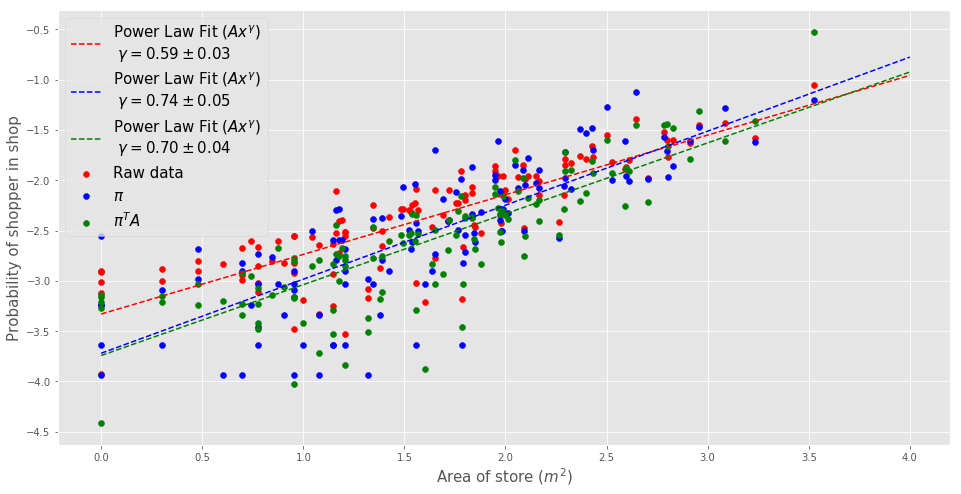

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.count_of_shoppers / sum(area_shop_df.count_of_shoppers)).tolist())
ax.scatter(x, y, c='r', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.pi / sum(area_shop_df.pi)).tolist())
ax.scatter(x, y, c='b', label='$\pi$')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.avpiA / sum(area_shop_df.avpiA)).tolist())
ax.scatter(x, y, c='g', label='$\pi^T A$')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Probability of shopper in shop', fontsize=15)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=15)

## Transition matrix network

In [20]:
import networkx as nx

In [21]:
G = nx.from_numpy_matrix(A[:20, :20], create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, dict(enumerate(le.inverse_transform(range(len(pi[:20]))))))

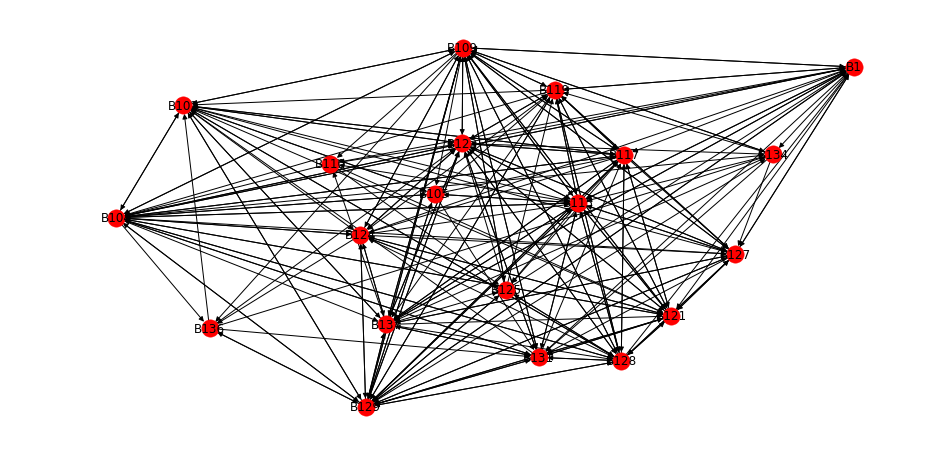

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
labels = {i : i for i in G.nodes()}
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, ax=ax)
nx.draw_networkx_labels(G, pos=pos, labels=labels);

In [23]:
A[:3, :3]

array([[ 0.36416185,  0.        ,  0.00192678],
       [ 0.        ,  0.08972268,  0.04893964],
       [ 0.00099157,  0.01636093,  0.22756569]])